In [173]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from Agents import QLearningAgent, BayesianQAgent, PSRLAgent, UbeNoUnrollAgent, MomentMatchingAgent
from Environments import DeepSea, WideNarrow, PriorMDP

from utils import solve_tabular_continuing_PI,   \
                  run_experiment,                \
                  run_oracle_experiment,         \
                  load_agent,                    \
                  get_agent_regret

from tqdm import tqdm_notebook as tqdm

# For saving figures and agents
if not os.path.exists('results'): os.mkdir('results')
if not os.path.exists('results/figures'): os.mkdir('results/figures')
if not os.path.exists('results/agent_logs'): os.mkdir('results/agent_logs')

fig_loc = 'results/figures/'

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=50)

In [174]:
# Agent parameters
agent_classes = [QLearningAgent, BayesianQAgent, PSRLAgent, UbeNoUnrollAgent, MomentMatchingAgent]
agent_names = ['QL', 'BQL', 'PSRL', 'UBE ($\\zeta = 0.1$)', 'MM ($\\zeta = 1.0$)']
agent_colors = ['black', 'purple', 'orange', 'green', 'deepskyblue']

agent_params = [{'gamma'            : 0.9,
                 'dither_param'     : 0.5,
                 'lr'               : 0.1,
                 'Q0'               : 0.0,
                 'anneal_timescale' : float('inf'),
                 'dither_mode'      : 'epsilon-greedy'},
                
                {'gamma'               : 0.9,
                 'mu0'                 : 0.0,
                 'lamda'               : 4.0,
                 'alpha'               : 3.0,
                 'beta'                : 3.0,
                 'num_mixture_samples' : 1000},
                
                {'gamma'            : 0.9,
                 'kappa'            : 1.0,
                 'mu0'              : 0.0,
                 'lamda'            : 4.0,
                 'alpha'            : 3.0,
                 'beta'             : 3.0},
               
                {'gamma'            : 0.9,
                 'kappa'            : 1.0,
                 'mu0'              : 0.0,
                 'lamda'            : 4.0,
                 'alpha'            : 3.0,
                 'beta'             : 3.0,
                 'zeta'             : 0.1,
                 'num_dyn_samples'  : 100},
               
                {'gamma'            : 0.9,
                 'kappa'            : 1.0,
                 'mu0'              : 0.0,
                 'lamda'            : 4.0,
                 'alpha'            : 3.0,
                 'beta'             : 3.0,
                 'zeta'             : 1.0,
                 'num_dyn_samples'  : 100}]

# DeepSea

In [175]:
deepsea_regrets = np.zeros(shape=(5, 5, 10))

for i, N in tqdm(enumerate([4, 6, 8, 10, 12])):

    num_time_steps = 1250 * N
    save_every = num_time_steps // 100
    
    delta = 1e-1 * np.exp(- N / 4)
    rew_params = ((0., delta), (-delta, delta), (1., delta))
    env_params = {'N'          :  N,
                  'episodic'   :  False,
                  'rew_params' :  rew_params}

    # Define environment
    environment = DeepSea(env_params)

    # Number of PI steps and maximum buffer length (PSRL, UBE and MM only)
    max_iter = 2 * N
    
    for j, (agent_class, agent_param) in enumerate(zip(agent_classes, agent_params)):
        
        agent_param['max_iter'] = max_iter
        agent_param['sa_list'] = environment.sa_list()
        agent_param['Rmax'] = environment.get_mean_P_and_R()[1].max()
        
        agent = agent_class(agent_param)
        
        max_buffer_length = 1 if j <= 1 else N + 1
        
        seeds = np.arange(10)
        
        for seed in seeds:
            
            environment.reset()
            
            rewards = get_agent_regret(environment,
                                       agent, 
                                       seeds=[seed], 
                                       num_time_steps=num_time_steps,
                                       max_iter=max_iter)
            
            deepsea_regrets[i, j, seed] = np.sum(rewards[1] - rewards[0], axis=-1) / np.sum(rewards[1], axis=-1)

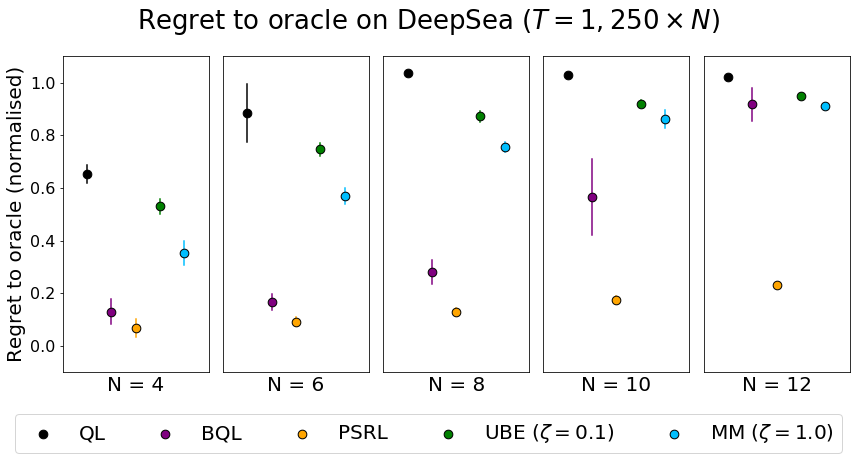

In [119]:
fig = plt.figure(figsize=(12, 6.5))

legend_obj = [None] * 5

for i, N in tqdm(enumerate([4, 6, 8, 10, 12])):
    plt.subplot(1, 5, i + 1)
    for j, agent_name in enumerate(agent_names):
        
        mean = deepsea_regrets[i, j].mean()
        std = deepsea_regrets[i, j].var()**0.5
        
        plt.plot([j, j], [mean - std, mean + std], color=agent_colors[j], zorder=1)
        legend_obj[j] = plt.scatter(j, mean, facecolor=agent_colors[j], edgecolor='k', linewidth=1, s=75, zorder=3)
        
    plt.xlim([-1, 5])
    plt.ylim([-0.1, 1.1])
    plt.xticks([])
    
    if i > 0:
        plt.yticks([])
    else:
        plt.ylabel('Regret to oracle (normalised)', fontsize=20)
        
    plt.xlabel('N = {}'.format(N), fontsize=20)
    
plt.suptitle('Regret to oracle on DeepSea ($T = 1,250 \\times N$)', fontsize=26)
plt.figlegend(legend_obj, agent_names, loc='lower center', ncol=5, labelspacing=0., fontsize=20)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.875)
plt.savefig(fig_loc + 'regret_summary_deepsea.pdf')
plt.show()

# WideNarrow

In [176]:
widenarrow_regrets = np.zeros(shape=(4, 5, 10))

for N in [1]:
    for i, W in tqdm(enumerate([6, 8, 10, 12])):

        num_time_steps = 1000 * N * W
        save_every = num_time_steps // 100

        mu_l, mu_h = 0.0, 0.5
        sig_l, sig_h = 1.0, 1.0

        rew_params = ((mu_l, sig_l), (mu_h, sig_h), (mu_l, sig_l))
        env_params = {'N'          : N,
                      'W'          : W,
                      'rew_params' : rew_params}

        # Define environment
        environment = WideNarrow(env_params)

        # Number of PI steps and maximum buffer length (PSRL, UBE and MM only)
        max_iter = 4 * N

        for j, (agent_class, agent_param) in enumerate(zip(agent_classes, agent_params)):

            agent_param['max_iter'] = max_iter
            agent_param['sa_list'] = environment.sa_list()
            agent_param['Rmax'] = environment.get_mean_P_and_R()[1].max()

            agent = agent_class(agent_param)
            
            max_buffer_length = 1 if i <= 1 else 2 * N + 1

            seeds = np.arange(10)

            for seed in seeds:

                environment.reset()

                rewards = get_agent_regret(environment,
                                           agent, 
                                           seeds=[seed], 
                                           num_time_steps=num_time_steps,
                                           max_iter=max_iter)

                widenarrow_regrets[i, j, seed] = np.sum(rewards[1] - rewards[0], axis=-1) \
                                                  / np.sum(rewards[1], axis=-1)

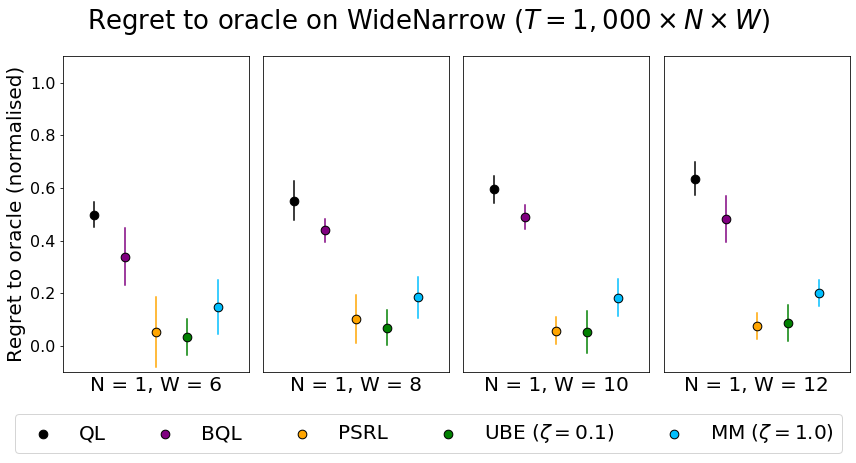

In [120]:
fig = plt.figure(figsize=(12, 6.5))

legend_obj = [None] * 5

for i, W in tqdm(enumerate([6, 8, 10, 12])):
    plt.subplot(1, 4, i + 1)
    for j, agent_name in enumerate(agent_names):
        
        mean = widenarrow_regrets[i, j].mean()
        std = widenarrow_regrets[i, j].var()**0.5
        
        plt.plot([j, j], [mean - std, mean + std], color=agent_colors[j], zorder=1)
        legend_obj[j] = plt.scatter(j, mean, facecolor=agent_colors[j], edgecolor='k', linewidth=1, s=75, zorder=3)
        
    plt.xlim([-1, 5])
    plt.ylim([-0.1, 1.1])
    plt.xticks([])
    
    if i > 0:
        plt.yticks([])
    else:
        plt.ylabel('Regret to oracle (normalised)', fontsize=20)
        
    plt.xlabel('N = 1, W = {}'.format(W), fontsize=20)
    
plt.suptitle('Regret to oracle on WideNarrow ($T = 1,000 \\times N \\times W$)', fontsize=26)
plt.figlegend(legend_obj, agent_names, loc='lower center', ncol=5, labelspacing=0., fontsize=20)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.875)
plt.savefig(fig_loc + 'regret_summary_widenarrow.pdf')
plt.show()

# PriorMDP

In [143]:
priormdp_regrets = np.zeros(shape=(4, 5, 10))

Ns = 4
Na = 2

for i, env_seed in enumerate(range(4)):

    num_time_steps = 1250 * Ns
    save_every = num_time_steps // 100

    env_params = {'Ns'         : Ns,
                  'Na'         : Na,
                  'kappa'      : 1.0,
                  'mu0'        : 0.0,
                  'lamda'      : 1.0,
                  'alpha'      : 4.0,
                  'beta'       : 4.0,
                  'seed'       : env_seed}

    # Define environment
    environment = PriorMDP(env_params)

    # Number of PI steps and maximum buffer length (PSRL, UBE and MM only)
    max_iter = 2 * Ns

    for j, (agent_class, agent_param) in enumerate(zip(agent_classes, agent_params)):

        agent_param['max_iter'] = max_iter
        agent_param['sa_list'] = environment.sa_list()
        agent_param['Rmax'] = environment.get_mean_P_and_R()[1].max()

        agent = agent_class(agent_param)

        max_buffer_length = 1 if j <= 1 else N + 1

        seeds = np.arange(10)

        for seed in seeds:

            environment.reset()

            rewards = get_agent_regret(environment,
                                       agent, 
                                       seeds=[seed], 
                                       num_time_steps=num_time_steps,
                                       max_iter=max_iter)
            
            priormdp_regrets[i, j, seed] = np.sum(rewards[1] - rewards[0], axis=-1) / np.sum(rewards[1], axis=-1)

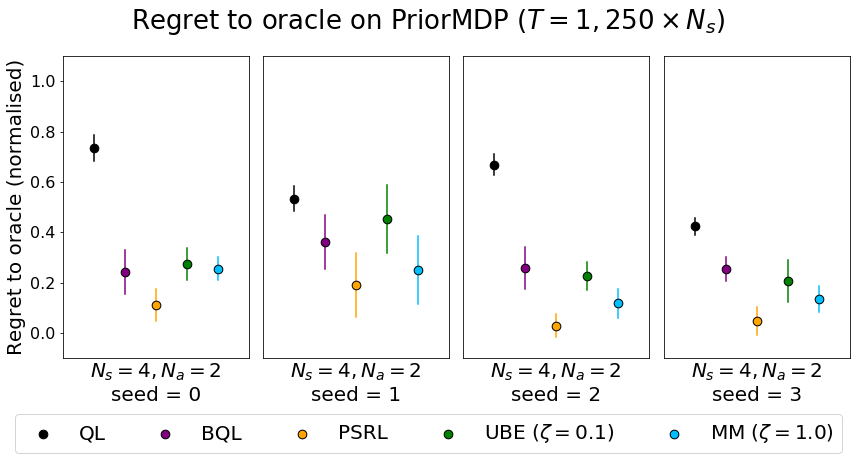

In [144]:
fig = plt.figure(figsize=(12, 6.5))

legend_obj = [None] * 5

for i, env_seed in tqdm(enumerate(range(4))):
    plt.subplot(1, 4, i + 1)
    for j, agent_name in enumerate(agent_names):
        
        mean = priormdp_regrets[i, j].mean()
        std = priormdp_regrets[i, j].var()**0.5
        
        plt.plot([j, j], [mean - std, mean + std], color=agent_colors[j], zorder=1)
        legend_obj[j] = plt.scatter(j, mean, facecolor=agent_colors[j], edgecolor='k', linewidth=1, s=75, zorder=3)
        
    plt.xlim([-1, 5])
    plt.ylim([-0.1, 1.1])
    plt.xticks([])
    
    if i > 0:
        plt.yticks([])
    else:
        plt.ylabel('Regret to oracle (normalised)', fontsize=20)
        
    plt.xlabel('$N_s = {}, N_a = {}$\nseed = {}'.format(Ns, Na, env_seed), fontsize=20)
    
plt.suptitle('Regret to oracle on PriorMDP ($T = 1,250 \\times N_s$)', fontsize=26)
plt.figlegend(legend_obj, agent_names, loc='lower center', ncol=5, labelspacing=0., fontsize=20)
plt.tight_layout()
fig.subplots_adjust(bottom=0.23, top=0.875)
plt.savefig(fig_loc + 'regret_summary_priormdp.pdf')
plt.show()

# Combined plot

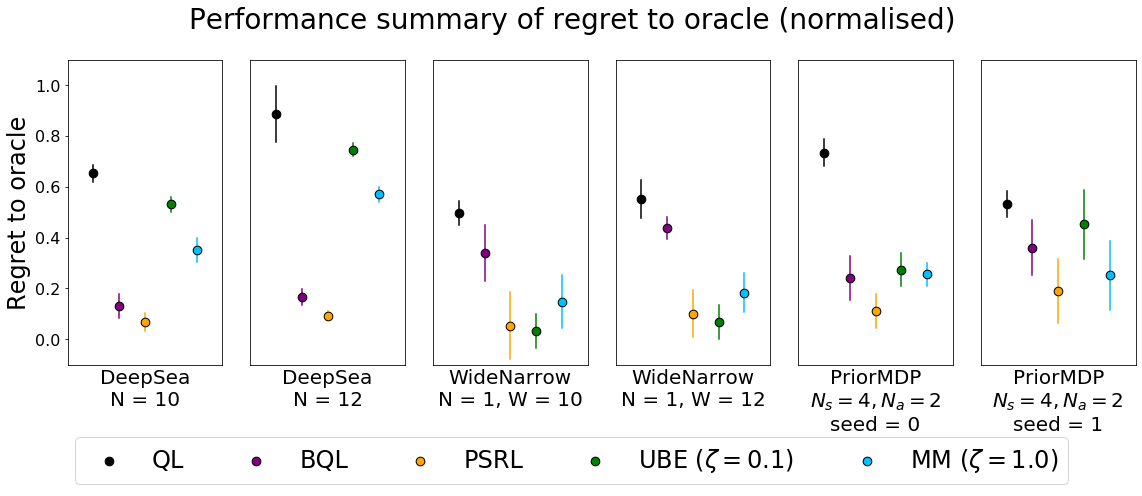

In [205]:
fig = plt.figure(figsize=(16, 7))

legend_obj = [None] * 5

for i, N in tqdm(enumerate([10, 12])):
    plt.subplot(1, 6, i + 1)
    for j, agent_name in enumerate(agent_names):
        
        mean = deepsea_regrets[i, j].mean()
        std = deepsea_regrets[i, j].var()**0.5
        
        plt.plot([j, j], [mean - std, mean + std], color=agent_colors[j], zorder=1)
        legend_obj[j] = plt.scatter(j, mean, facecolor=agent_colors[j], edgecolor='k', linewidth=1, s=75, zorder=3)
        
    plt.xlim([-1, 5])
    plt.ylim([-0.1, 1.1])
    plt.xticks([])
    
    if i > 0:
        plt.yticks([])
    else:
        plt.ylabel('Regret to oracle', fontsize=24)
        
    plt.xlabel('DeepSea\nN = {}'.format(N), fontsize=20)
    

for i, W in tqdm(enumerate([10, 12])):
    plt.subplot(1, 6, i + 3)
    for j, agent_name in enumerate(agent_names):
        
        mean = widenarrow_regrets[i, j].mean()
        std = widenarrow_regrets[i, j].var()**0.5
        
        plt.plot([j, j], [mean - std, mean + std], color=agent_colors[j], zorder=1)
        legend_obj[j] = plt.scatter(j, mean, facecolor=agent_colors[j], edgecolor='k', linewidth=1, s=75, zorder=3)
        
    plt.xlim([-1, 5])
    plt.ylim([-0.1, 1.1])
    plt.xticks([])
    plt.yticks([])
        
    plt.xlabel('WideNarrow\nN = 1, W = {}'.format(W), fontsize=20)
    

for i, env_seed in tqdm(enumerate(range(2))):
    plt.subplot(1, 6, i + 5)
    for j, agent_name in enumerate(agent_names):
        
        mean = priormdp_regrets[i, j].mean()
        std = priormdp_regrets[i, j].var()**0.5
        
        plt.plot([j, j], [mean - std, mean + std], color=agent_colors[j], zorder=1)
        legend_obj[j] = plt.scatter(j, mean, facecolor=agent_colors[j], edgecolor='k', linewidth=1, s=75, zorder=3)
        
    plt.xlim([-1, 5])
    plt.ylim([-0.1, 1.1])
    plt.xticks([])
    plt.yticks([])
        
    plt.xlabel('PriorMDP\n$N_s = {}, N_a = {}$\nseed = {}'.format(Ns, Na, env_seed), fontsize=20)
    
plt.suptitle('Performance summary of regret to oracle (normalised)', fontsize=28)
plt.figlegend(legend_obj, agent_names, loc='lower center', ncol=5, labelspacing=0., fontsize=24)
plt.tight_layout()
fig.subplots_adjust(bottom=0.27, top=0.875)
plt.savefig(fig_loc + 'regret_combined.pdf')
plt.show()